In [45]:
# /// script
# dependencies = [
# "scipy",
# "numpy",
# "matplotlib",
# "pandas",
# "openpyxl",
# ]
# ///
# AS PER PYTHON STYLE GUIDES FOR REQUIRED PACKAGES ^

import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from copy import deepcopy

# Specific fxns, ect.
from scipy.stats import linregress

In [46]:
# KNOWN DATA -- UPDATE AS NEEDED


class Electrolyte():
    """
    Wrapper class for electrolyte data
    """

    def __init__(self, conc, kin_visc, t_p, DAT) -> None:
        self.conc = conc # MOLAR
        self.kin_visc = kin_visc # CM^2 / S
        self.t_p = t_p # UNITLESS

        if isinstance(DAT, str):
            self.data = pd.read_excel(DAT)
        else:
            self.data = DAT

# Initialize electrolyte data

E1 = Electrolyte(1, 0.025, 0.36, "Electrolyte1_RDE_data.xlsx")
E2 = Electrolyte(4, 0.1, 0.55, "Electrolyte2_RDE_data.xlsx")
E3 = Electrolyte(1, 0.2, 0.25, "Electrolyte3_RDE_data.xlsx")

data = [E1, E2, E3]
E1.data.head()


,V (mV),Current Density (mA/cm2)
0,0.000000,5.781907
1,1.101101,5.554195
2,2.202202,5.596112
3,3.303303,5.745230
4,4.404404,5.652301


## 1a

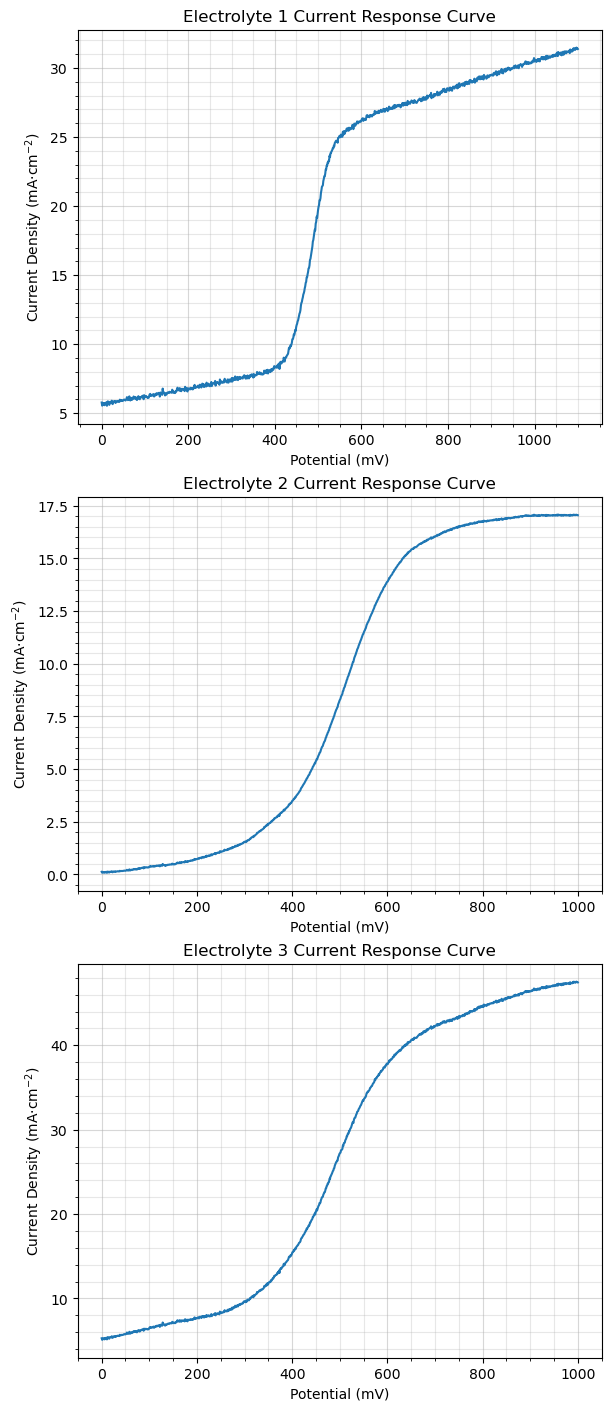

In [50]:
fig, axes = plt.subplots(3, 1, layout='constrained', figsize=(6,14))

for idx, ax in enumerate(axes):
    ax.set_title(f'Electrolyte {idx+1} Current Response Curve')
    ax.plot(data[idx].data['V (mV)'], data[idx].data['Current Density (mA/cm2)'])
    ax.set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
    ax.set_xlabel("Potential (mV)")
    ax.minorticks_on()
    ax.grid(which='both', alpha=0.3)
    ax.grid(which='major', alpha=0.5)

## 1b

In [54]:
def linfit_range(electrolyte: Electrolyte, minV, maxV):
    data = electrolyte.data

    data_in_range = data[data['V (mV)'].between(minV, maxV)]

    voltages = data_in_range['V (mV)']
    currents = data_in_range['Current Density (mA/cm2)']

    return linregress(voltages, currents)
    

## 1c

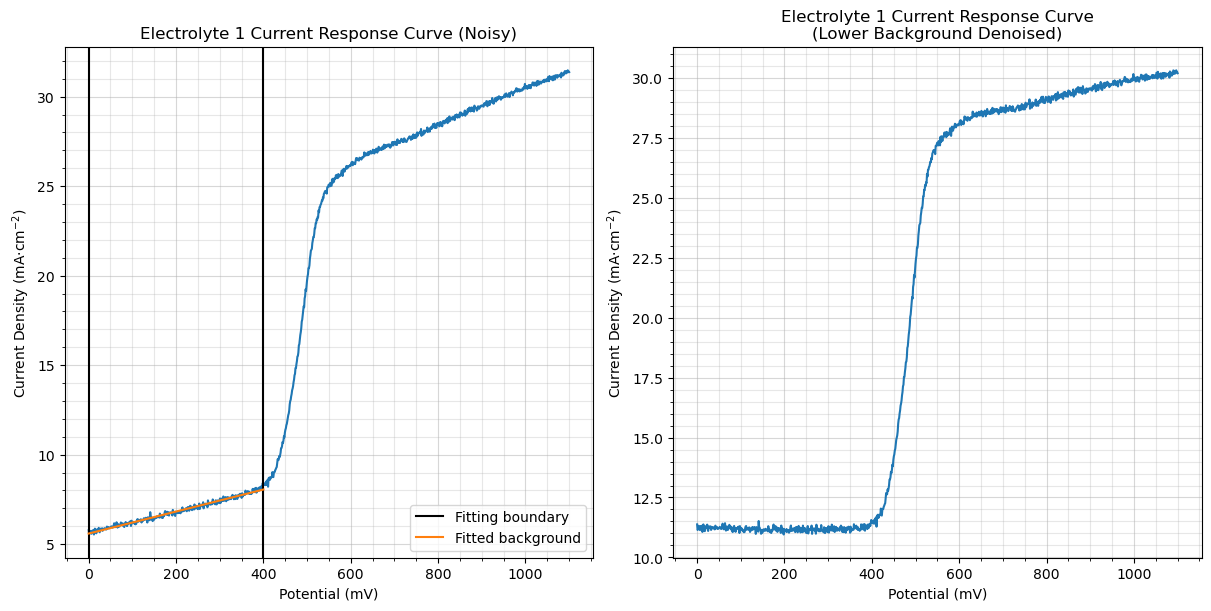

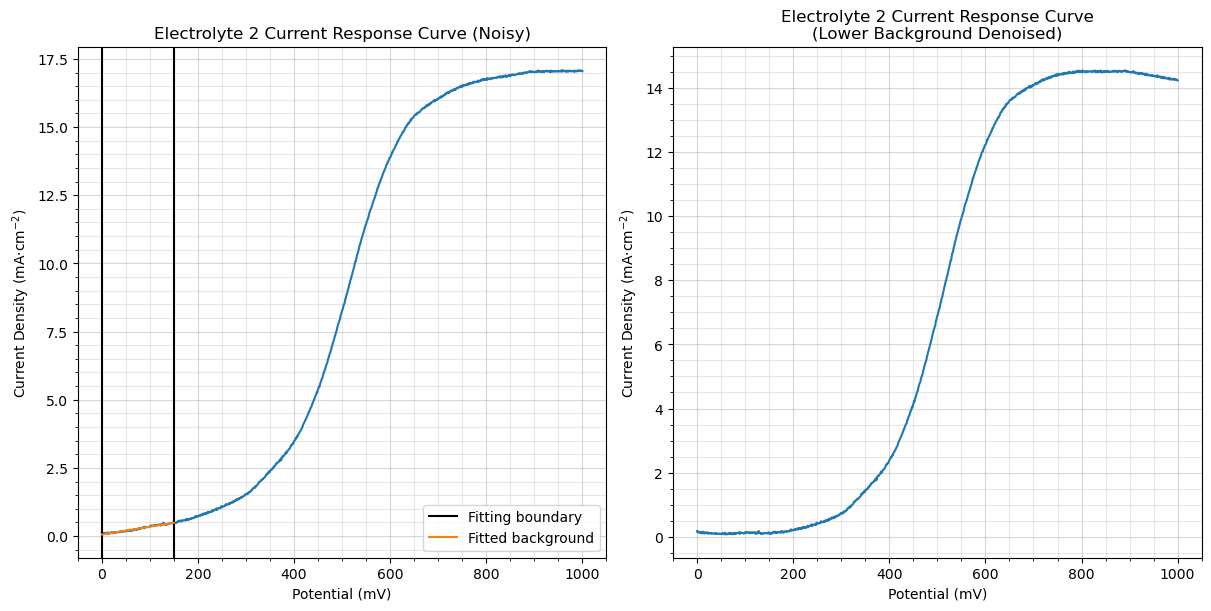

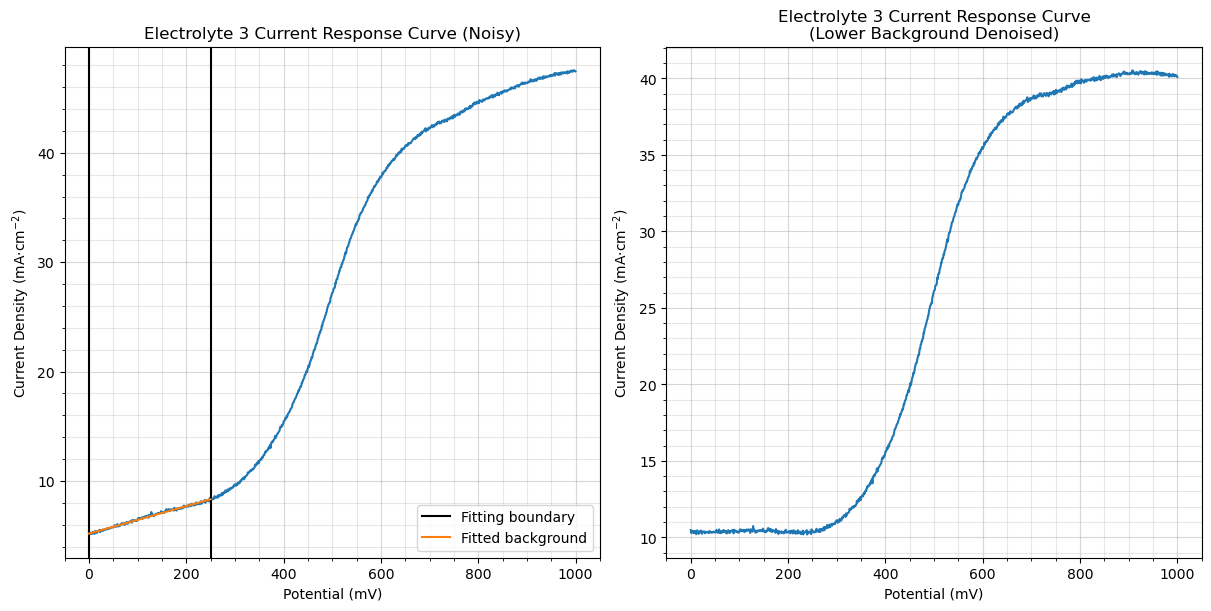

In [ ]:
# Subtract background

def subtract_bgnd(electrolyte, idx, minV, maxV, graph=True):
    data = electrolyte.data.copy(deep=True)
    regress = linfit_range(electrolyte, minV, maxV)

    delta_fxn = lambda x, y: y - regress.slope*x + regress.intercept

    if graph == True:
        fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', figsize=(12, 6))
        ax1.set_title(f'Electrolyte {idx} Current Response Curve (Noisy)')
        ax1.plot(electrolyte.data['V (mV)'], electrolyte.data['Current Density (mA/cm2)'])
        ax1.axvline(minV, color="black", label='Fitting boundary')
        ax1.axvline(maxV, color="black")
        regress_range = np.linspace(minV, maxV, 1000)
        ax1.plot(regress_range, [regress.slope*x + regress.intercept for x in regress_range], label='Fitted background')
        ax1.set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
        ax1.set_xlabel("Potential (mV)")
        ax1.minorticks_on()
        ax1.grid(which='both', alpha=0.3)
        ax1.grid(which='major', alpha=0.5)
        ax1.legend()

    # Change data and graph changed data
    data['Current Density (mA/cm2)'] = list(map(delta_fxn, data['V (mV)'], data['Current Density (mA/cm2)']))

    if graph == True:
        ax2.set_title(f'Electrolyte {idx} Current Response Curve\n(Lower Background Denoised)')
        ax2.plot(data['V (mV)'], data['Current Density (mA/cm2)'])
        ax2.set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
        ax2.set_xlabel("Potential (mV)")
        ax2.minorticks_on()
        ax2.grid(which='both', alpha=0.3)
        ax2.grid(which='major', alpha=0.5)

        plt.show(fig)

    return Electrolyte(
        electrolyte.conc,
        electrolyte.kin_visc,
        electrolyte.t_p,
        data
    )

subtract_bgnd(E1, 1, 0, 400)
subtract_bgnd(E2, 2, 0, 150)
subtract_bgnd(E3, 3, 0, 250)

## 1d

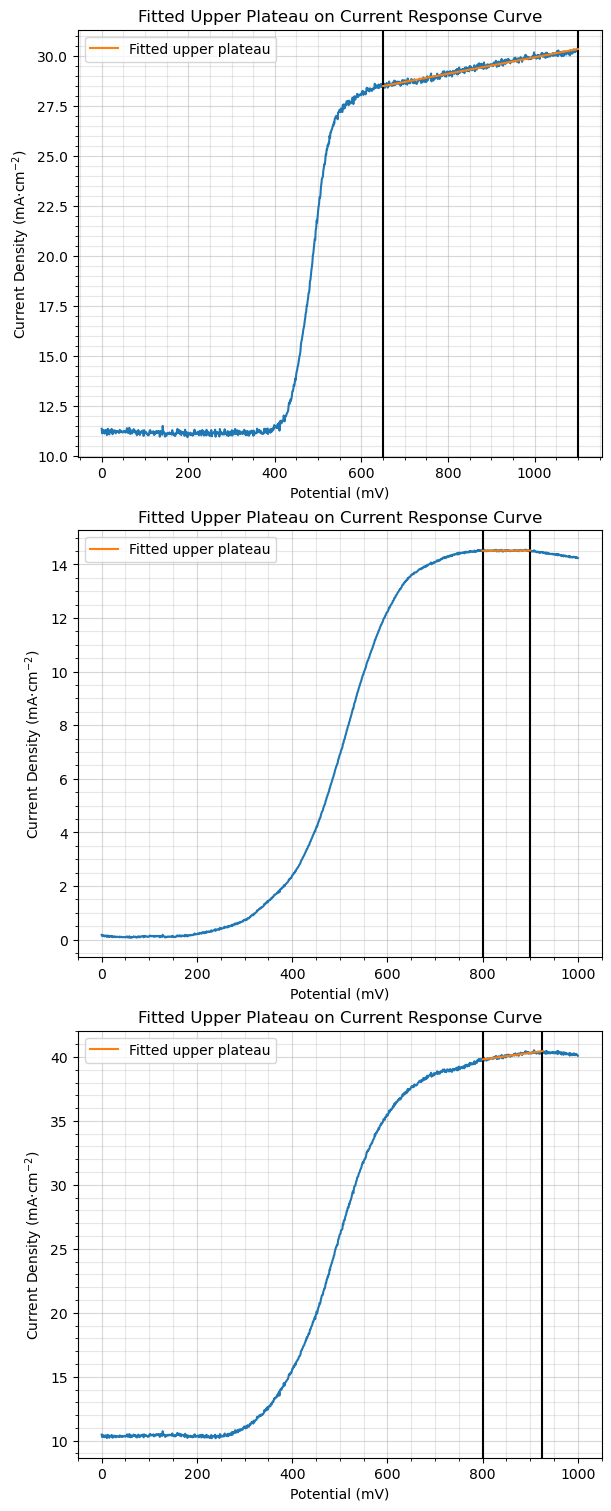

In [76]:
E1_base = subtract_bgnd(E1, 1, 0, 400, graph=False)
E2_base = subtract_bgnd(E2, 2, 0, 150, graph=False)
E3_base = subtract_bgnd(E3, 3, 0, 250, graph=False)

corrected_data = [E1_base, E2_base, E3_base]

start_end = [
    (650, 1100),
    (800, 900),
    (800, 925)
]

fitted_uppers = []

fig, axes = plt.subplots(3, 1, figsize=(6, 15), layout='constrained')
for idx, e in enumerate(corrected_data):
    # Find upper bound
    axes[idx].set_title(f'Fitted Upper Plateau on Current Response Curve')
    axes[idx].set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
    axes[idx].set_xlabel("Potential (mV)")
    cdata = corrected_data[idx].data
    start = start_end[idx][0]
    end = start_end[idx][1]
    upper_fit = linfit_range(e, start, end)
    fitted_uppers.append(upper_fit)
    axes[idx].plot(cdata['V (mV)'], cdata['Current Density (mA/cm2)'])
    N = np.linspace(start, end, 1000)
    axes[idx].axvline(start, color='black')
    axes[idx].axvline(end, color='black')
    axes[idx].plot(N, [upper_fit.slope*n + upper_fit.intercept for n in N], label=r'Fitted upper plateau')
    axes[idx].minorticks_on()
    axes[idx].grid(which='both', alpha=0.3)
    axes[idx].grid(which='major', alpha=0.5)
    axes[idx].legend()


## 1e